# Predicción de defunciones en pacientes por Covid-19

Porfirio Ángel Díaz Sánchez

## Introducción

La aparición del Covid-19 es uno de los mayores retos en materia de salud que el mundo se ha enfrentado en los últimos años, tanto así que, en cuestión de meses, ha ocasionado un cambio radical en la vida cotidiana de mucha gente, además de que es un problema global que rápidamente se ha esparcido por el planeta.

A pesar de que su nivel de mortalidad no es tan alto, dicha enfermedad es muy contagiosa, por lo que los sistemas de salud corren el riesgo de sobresaturarse, provocando que no sea posible atender a todos los pacientes de forma adecuada y oportuna. Esto representa un problema, porque si bien, no todas las personas infectadas por Covid-19 requieren hospitalización, hay muchas otras que sí lo necesitan y el hecho de no poder ser atendidas puede aumentar el riesgo de complicaciones y muerte.

En el presente trabajo, se utiliza el análisis y procesamiento de información para determinar si un paciente que se realiza la prueba de Covid-19, tomando en cuenta sus características de salud y de atención ante la enfermedad anteriormente mencionada, morirá en algún momento del desarrollo de su padecimiento.

## Utilidades de código

En las celdas de esta sección se implementan algunas funciones de utilidad en el manejo de los dataframes, son acciones comunes que suelen hacerse al llevar a cabo estas tareas, por eso su código se extrajo para poder hacerlo reutilizable.

In [148]:
# Obtiene la intersección entre dos listas.
def list_intersection(list1, list2): 
    return list(set(list1) & set(list2)) 

In [149]:
# Obtiene la diferencia entre dos listas.
def list_diff(list1, list2): 
    return (list(set(list1) - set(list2))) 

In [150]:
# Elimina un conjunto de atributos de un dataframe.
def drop_attributes(df, attributes):
    for attr in attributes:
        try:
            df.drop(attr, 1, inplace=True)
            print(f'Se eliminó atributo {attr}')
        except Exception as e:
            print(f'El atributo {attr} no existe')

In [151]:
# Grafica la cantidad de valores únicos que hay en cada atributo de un dataframe.
def plot_unique(df):
    uq_data = {'clase': []}
    uq_columns=['clase']

    for col in df.columns:
        unique = len(df[col].unique())

        for i in range(unique):
            uq_data['clase'].append(col)

    classes = pd.DataFrame(uq_data, columns=uq_columns)
    classes['clase'].value_counts().plot(kind='bar', figsize=(15, 5))
    plt.title('Cantidad de valores únicos por atributo')
    plt.show()

In [152]:
# Determina si un conjunto de valores corresponden al catálogo si_no.
def is_si_no(values):
    for value in values:
        if value not in [1, 2, 97, 98, 99]:
            return False
    return True

In [153]:
# Recodifica los valores numéricos para valores correspondientes a catálogo si_no.
def recode_si_no(df):
    for col in df.columns:
        si_no = is_si_no(df[col].unique())
        
        if si_no:
            df[col] = df[col].mask(df[col] == 97, 3)
            df[col] = df[col].mask(df[col] == 98, 4)
            df[col] = df[col].mask(df[col] == 99, 4)

In [154]:
# Identifica cuáles variables de un dataset tienen un valor alfanumérico.
def separate_nums_and_strings(df):
    strings = []
    numeric = []
    
    for col in df.columns:
        col_name = str(col)
        try:
            df[col_name] = df[col_name].astype(float)
            numeric.append(col_name)
        except Exception:
            strings.append(col_name)
            
    return {
        'numeric': numeric,
        'strings': strings
    }

In [155]:
# Parsea un conjunto de características para que sean reconocidas como
# categorías.
def parse_categories(df, categories):
    for cat in categories:
        category_values = []
        unique = df[cat].unique()        
        df[cat] = pd.Categorical(df[cat], unique, ordered=False)
    print('Se parsearon los datos categóricos para ser interpretados como tal')

In [156]:
# Codifica un conjunto de características categóricas a numéricas.
def code_categories(df, categories):
    for cat in categories:
        df[cat] = df[cat].cat.codes
    print('Las categorías fueron codificadas')

In [157]:
# Ejecuta función describe() para cada característica de un dataframe.
def describe_attributes(df):
    for col in df.columns:
        col_name = str(col)
        print()
        print('-' * len(col_name))
        print(col_name)
        if str(df[col].dtype) == 'category':
            counts = df[col].value_counts()
            percentaje = df[col].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'
            print(pd.DataFrame({'counts': counts, 'percentaje': percentaje}))
        else:
            print(df[col].describe())

In [158]:
# Grafica la descripción de los atributos de un dataset.
def plot_attributes_description(df):
    cols_count = len(df.columns)
    plt_cols = 3
    plt_rows = int(np.ceil(cols_count / plt_cols))
    fig = plt.figure(figsize=(15, 80))
    df_to_plot = None
    i = 0
    
    for col in df.columns:
        col_name = str(col)
        print(f'Plotting {col_name} description')
        if str(df[col].dtype) == 'category':
            counts = df[col].value_counts()
            percentage = df[col].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'
            description_df = pd.DataFrame({'counts': counts, 'percentage': percentage})
            ax = fig.add_subplot(plt_rows, plt_cols, (i + 1))
            description_df.plot(ax=ax, kind='bar')
            plt.title(col_name)
        else:
            #pass
            ax = fig.add_subplot(plt_rows, plt_cols, (i + 1))
            df[col].plot(ax=ax, kind='hist')
            
        i += 1
        
    plt.show()

## Obtención de los datos

Por medio del sitio oficial de Datos Abiertos del Gobierno de la República, el gobierno mexicano pone al alcance de los ciudadanos diversos catálogos de datos digitales acerca de diversos temas de interés nacional para su libre consulta y análisis.

La base de datos utilizada en el presente trabajo registra aspectos de salud, resultados de pruebas, evolución de enfermedad, así como otras características de los pacientes que presentaron síntomas de Covid-19 en México. Los datos se utilizan con el objetivo de determinar los aspectos que influyen en que un paciente con síntomas de Covid-19, muera.

### Descripción del dataset

|Nº |NOMBRE DE VARIABLE |DESCRIPCIÓN DE VARIABLE                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |FORMATO O FUENTE                                                                  |
|---|-------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------|
|1  |FECHA_ACTUALIZACION|La base de datos se alimenta diariamente, esta variable permite identificar la fecha de la ultima actualizacion.                                                                                                                                                                                                                                                                                                                                                                                |AAAA-MM-DD                                                                        |
|2  |ID_REGISTRO        |Número identificador del caso                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |TEXTO                                                                             |
|3  |ORIGEN             |La vigilancia centinela se realiza a través del sistema de unidades de salud monitoras de enfermedades respiratorias (USMER). Las USMER incluyen unidades médicas del primer, segundo o tercer nivel de atención y también participan como USMER las unidades de tercer nivel que por sus características contribuyen a ampliar el panorama de información epidemiológica, entre ellas las que cuenten con especialidad de neumología, infectología o pediatría. (Categorías en Catalógo Anexo).|CATÁLOGO: ORIGEN                                                                  |
|4  |SECTOR             |Identifica el tipo de institución del Sistema Nacional de Salud que brindó la atención.                                                                                                                                                                                                                                                                                                                                                                                                         |CATÁLOGO: SECTOR                                                                  |
|5  |ENTIDAD_UM         |Identifica la entidad donde se ubica la unidad medica que brindó la atención.                                                                                                                                                                                                                                                                                                                                                                                                                   |CATALÓGO: ENTIDADES                                                               |
|6  |SEXO               |Identifica al sexo del paciente.                                                                                                                                                                                                                                                                                                                                                                                                                                                                |CATÁLOGO: SEXO                                                                    |
|7  |ENTIDAD_NAC        |Identifica la entidad de nacimiento del paciente.                                                                                                                                                                                                                                                                                                                                                                                                                                               |CATALÓGO: ENTIDADES                                                               |
|8  |ENTIDAD_RES        |Identifica la entidad de residencia del paciente.                                                                                                                                                                                                                                                                                                                                                                                                                                               |CATALÓGO: ENTIDADES                                                               |
|9  |MUNICIPIO_RES      |Identifica el municipio de residencia del paciente.                                                                                                                                                                                                                                                                                                                                                                                                                                             |CATALÓGO: MUNICIPIOS                                                              |
|10 |TIPO_PACIENTE      |Identifica el tipo de atención que recibió el paciente en la unidad. Se denomina como ambulatorio si regresó a su casa o se denomina como hospitalizado si fue ingresado a hospitalización.                                                                                                                                                                                                                                                                                                     |CATÁLOGO: TIPO_PACIENTE                                                           |
|11 |FECHA_INGRESO      |Identifica la fecha de ingreso del paciente a la unidad de atención.                                                                                                                                                                                                                                                                                                                                                                                                                            |AAAA-MM-DD                                                                        |
|12 |FECHA_SINTOMAS     |Idenitifica la fecha en que inició la sintomatología del paciente.                                                                                                                                                                                                                                                                                                                                                                                                                              |AAAA-MM-DD                                                                        |
|13 |FECHA_DEF          |Identifica la fecha en que el paciente falleció.                                                                                                                                                                                                                                                                                                                                                                                                                                                |AAAA-MM-DD                                                                        |
|14 |INTUBADO           |Identifica si el paciente requirió de intubación.                                                                                                                                                                                                                                                                                                                                                                                                                                               |CATÁLOGO: SI_ NO                                                                  |
|15 |NEUMONIA           |Identifica si al paciente se le diagnosticó con neumonía.                                                                                                                                                                                                                                                                                                                                                                                                                                       |CATÁLOGO: SI_ NO                                                                  |
|16 |EDAD               |Identifica la edad del paciente.                                                                                                                                                                                                                                                                                                                                                                                                                                                                |NÚMERICA EN AÑOS                                                                  |
|17 |NACIONALIDAD       |Identifica si el paciente es mexicano o extranjero.                                                                                                                                                                                                                                                                                                                                                                                                                                             |CATÁLOGO: NACIONALIDAD                                                            |
|18 |EMBARAZO           |Identifica si la paciente está embarazada.                                                                                                                                                                                                                                                                                                                                                                                                                                                      |CATÁLOGO: SI_ NO                                                                  |
|19 |HABLA_LENGUA_INDIG |Identifica si el paciente habla lengua índigena.                                                                                                                                                                                                                                                                                                                                                                                                                                                |CATÁLOGO: SI_ NO                                                                  |
|20 |DIABETES           |Identifica si el paciente tiene un diagnóstico de diabetes.                                                                                                                                                                                                                                                                                                                                                                                                                                     |CATÁLOGO: SI_ NO                                                                  |
|21 |EPOC               |Identifica si el paciente tiene un diagnóstico de EPOC.                                                                                                                                                                                                                                                                                                                                                                                                                                         |CATÁLOGO: SI_ NO                                                                  |
|22 |ASMA               |Identifica si el paciente tiene un diagnóstico de asma.                                                                                                                                                                                                                                                                                                                                                                                                                                         |CATÁLOGO: SI_ NO                                                                  |
|23 |INMUSUPR           |Identifica si el paciente presenta inmunosupresión.                                                                                                                                                                                                                                                                                                                                                                                                                                             |CATÁLOGO: SI_ NO                                                                  |
|24 |HIPERTENSION       |Identifica si el paciente tiene un diagnóstico de hipertensión.                                                                                                                                                                                                                                                                                                                                                                                                                                 |CATÁLOGO: SI_ NO                                                                  |
|25 |OTRAS_COM          |Identifica si el paciente tiene diagnóstico de otras enfermedades.                                                                                                                                                                                                                                                                                                                                                                                                                              |CATÁLOGO: SI_ NO                                                                  |
|26 |CARDIOVASCULAR     |Identifica si el paciente tiene un diagnóstico de enfermedades cardiovasculares.                                                                                                                                                                                                                                                                                                                                                                                                                |CATÁLOGO: SI_ NO                                                                  |
|27 |OBESIDAD           |Identifica si el paciente tiene diagnóstico de obesidad.                                                                                                                                                                                                                                                                                                                                                                                                                                        |CATÁLOGO: SI_ NO                                                                  |
|28 |RENAL_CRONICA      |Identifica si el paciente tiene diagnóstico de insuficiencia renal crónica.                                                                                                                                                                                                                                                                                                                                                                                                                     |CATÁLOGO: SI_ NO                                                                  |
|29 |TABAQUISMO         |Identifica si el paciente tiene hábito de tabaquismo.                                                                                                                                                                                                                                                                                                                                                                                                                                           |CATÁLOGO: SI_ NO                                                                  |
|30 |OTRO_CASO          |Identifica si el paciente tuvo contacto con algún otro caso diagnósticado con SARS CoV-2                                                                                                                                                                                                                                                                                                                                                                                                        |CATÁLOGO: SI_ NO                                                                  |
|31 |RESULTADO          |Identifica el resultado del análisis de la muestra reportado por el  laboratorio de la Red Nacional de Laboratorios de Vigilancia Epidemiológica (INDRE, LESP y LAVE). (Catálogo de resultados diagnósticos anexo).                                                                                                                                                                                                                                                                             |CATÁLOGO: RESULTADO                                                               |
|32 |MIGRANTE           |Identifica si el paciente es una persona migrante.                                                                                                                                                                                                                                                                                                                                                                                                                                              |CATÁLOGO: SI_ NO                                                                  |
|33 |PAIS_NACIONALIDAD  |Identifica la nacionalidad del paciente.                                                                                                                                                                                                                                                                                                                                                                                                                                                        |TEXTO, 99= SE IGNORA                                                              |
|34 |PAIS_ORIGEN        |Identifica el país del que partió el paciente rumbo a México.                                                                                                                                                                                                                                                                                                                                                                                                                                   |TEXTO, 97= NO APLICA                                                              |
|35 |UCI                |Identifica si el paciente requirió ingresar a una Unidad de Cuidados Intensivos.                                                                                                                                                                                                                                                                                                                                                                                                                |CATÁLOGO: SI_ NO                                                                  |


#### Catálogo ORIGEN

|CLAVE|DESCRIPCIÓN        |
|-----|-------------------|
|1    |USMER              |
|2    |FUERA DE USMER     |
|99   |NO ESPECIFICADO    |

#### Catálogo SECTOR

|CLAVE|DESCRIPCIÓN        |
|-----|-------------------|
|1    |CRUZ ROJA          |
|2    |DIF                |
|3    |ESTATAL            |
|4    |IMSS               |
|5    |IMSS-BIENESTAR     |
|6    |ISSSTE             |
|7    |MUNICIPAL          |
|8    |PEMEX              |
|9    |PRIVADA            |
|10   |SEDENA             |
|11   |SEMAR              |
|12   |SSA                |
|13   |UNIVERSITARIO      |
|99   |NO ESPECIFICADO    |


#### Catálogo SEXO

|CLAVE|DESCRIPCIÓN        |
|-----|-------------------|
|1    |MUJER              |
|2    |HOMBRE             |
|99   |NO ESPECIFICADO    |

#### Catálogo TIPO_PACIENTE

|CLAVE|DESCRIPCIÓN        |
|-----|-------------------|
|1    |AMBULATORIO        |
|2    |HOSPITALIZADO      |
|99   |NO ESPECIFICADO    |

#### Catálogo SI_NO

|CLAVE|DESCRIPCIÓN        |
|-----|-------------------|
|1    |SI                 |
|2    |NO                 |
|97   |NO APLICA          |
|98   |SE IGNORA          |
|99   |NO ESPECIFICADO    |

#### Catálogo NACIONALIDAD

|CLAVE|DESCRIPCIÓN        |
|-----|-------------------|
|1    |MEXICANA           |
|2    |EXTRANJERA         |
|99   |NO ESPECIFICADO    |

#### Catálogo RESULTADO

|CLAVE|DESCRIPCIÓN        |
|-----|-------------------|
|1    |Positivo SARS-CoV-2|
|2    |No positivo SARS-CoV-2|
|3    |Resultado pendiente|

#### Catálogo ENTIDADES

|CLAVE_ENTIDAD|ENTIDAD_FEDERATIVA |ABREVIATURA|
|-------------|-------------------|-----------|
|01           |AGUASCALIENTES     |AS         |
|02           |BAJA CALIFORNIA    |BC         |
|03           |BAJA CALIFORNIA SUR|BS         |
|04           |CAMPECHE           |CC         |
|05           |COAHUILA DE ZARAGOZA|CL         |
|06           |COLIMA             |CM         |
|07           |CHIAPAS            |CS         |
|08           |CHIHUAHUA          |CH         |
|09           |CIUDAD DE MÉXICO   |DF         |
|10           |DURANGO            |DG         |
|11           |GUANAJUATO         |GT         |
|12           |GUERRERO           |GR         |
|13           |HIDALGO            |HG         |
|14           |JALISCO            |JC         |
|15           |MÉXICO             |MC         |
|16           |MICHOACÁN DE OCAMPO|MN         |
|17           |MORELOS            |MS         |
|18           |NAYARIT            |NT         |
|19           |NUEVO LEÓN         |NL         |
|20           |OAXACA             |OC         |
|21           |PUEBLA             |PL         |
|22           |QUERÉTARO          |QT         |
|23           |QUINTANA ROO       |QR         |
|24           |SAN LUIS POTOSÍ    |SP         |
|25           |SINALOA            |SL         |
|26           |SONORA             |SR         |
|27           |TABASCO            |TC         |
|28           |TAMAULIPAS         |TS         |
|29           |TLAXCALA           |TL         |
|30           |VERACRUZ DE IGNACIO DE LA LLAVE|VZ         |
|31           |YUCATÁN            |YN         |
|32           |ZACATECAS          |ZS         |
|36           |ESTADOS UNIDOS MEXICANOS|EUM        |
|97           |NO APLICA          |NA         |
|98           |SE IGNORA          |SI         |
|99           |NO ESPECIFICADO    |NE         |

### Lectura del dataset

In [159]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [160]:
data = pd.read_csv('data/200630COVID19MEXICO.csv', encoding='ISO-8859-1')

## Preprocesamiento

### Visualización previa

A continuación se muestran algunos registros del dataset, con la finalidad de tener una idea de qué datos se están capturando.

In [161]:
data

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,RESULTADO,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,2020-06-30,04f3dd,2,3,25,2,25,25,6,1,...,2,2,2,2,1,1,99,MÃ©xico,99,97
1,2020-06-30,1b7c4b,2,3,27,1,27,27,5,2,...,1,2,2,2,2,1,99,MÃ©xico,99,2
2,2020-06-30,03f6dd,2,4,9,1,9,15,58,1,...,2,1,2,2,99,1,99,MÃ©xico,99,97
3,2020-06-30,187fc7,2,4,15,2,15,15,122,2,...,2,2,2,2,99,1,99,MÃ©xico,99,2
4,2020-06-30,1795a0,2,3,2,2,2,2,2,1,...,2,2,2,2,1,1,99,MÃ©xico,99,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581575,2020-06-30,0c4756,2,12,9,1,9,9,15,1,...,2,2,2,2,2,3,99,MÃ©xico,99,97
581576,2020-06-30,034009,1,12,26,1,26,26,18,1,...,2,1,2,2,2,3,99,MÃ©xico,99,97
581577,2020-06-30,01b2a3,2,9,9,1,9,9,3,1,...,2,2,2,2,1,3,99,MÃ©xico,99,97
581578,2020-06-30,0d0a6f,2,12,12,2,12,12,1,1,...,2,2,2,2,1,3,99,MÃ©xico,99,97


En la siguiente celda se muestran las medidas de tendencia central, correspondientes a las 28 variables numéricas existentes en el dataset.

In [162]:
data.describe()

,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,INTUBADO,NEUMONIA,...,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,RESULTADO,MIGRANTE,UCI
count,581580.000000,581580.000000,581580.000000,581580.000000,581580.000000,581580.000000,581580.000000,581580.00000,581580.000000,581580.000000,...,581580.000000,581580.000000,581580.000000,581580.000000,581580.000000,581580.000000,581580.000000,581580.000000,581580.000000,581580.000000
mean,1.644398,9.729633,15.350581,1.506420,16.306854,15.624349,38.712330,1.21389,76.683213,1.847232,...,2.144981,2.408300,2.285251,2.137407,2.282377,2.236944,31.543710,1.735122,98.604125,76.683256
std,0.478696,8.025583,8.041466,0.499959,10.110272,7.939361,49.925215,0.41005,38.975078,0.556082,...,5.452304,6.475781,5.429454,5.380778,5.380994,5.557109,45.070146,0.665177,6.194062,38.975205
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,4.000000,9.000000,1.000000,9.000000,9.000000,7.000000,1.00000,97.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,99.000000,97.000000
50%,2.000000,12.000000,14.000000,2.000000,15.000000,15.000000,21.000000,1.00000,97.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,99.000000,97.000000
75%,2.000000,12.000000,21.000000,2.000000,22.000000,21.000000,50.000000,1.00000,97.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,99.000000,2.000000,99.000000,97.000000
max,2.000000,99.000000,32.000000,2.000000,99.000000,32.000000,999.000000,2.00000,99.000000,99.000000,...,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,99.000000,3.000000,99.000000,99.000000


En la gráfica que aparece abajo, se plasman las correlaciones individuales que existen entre los atributos.

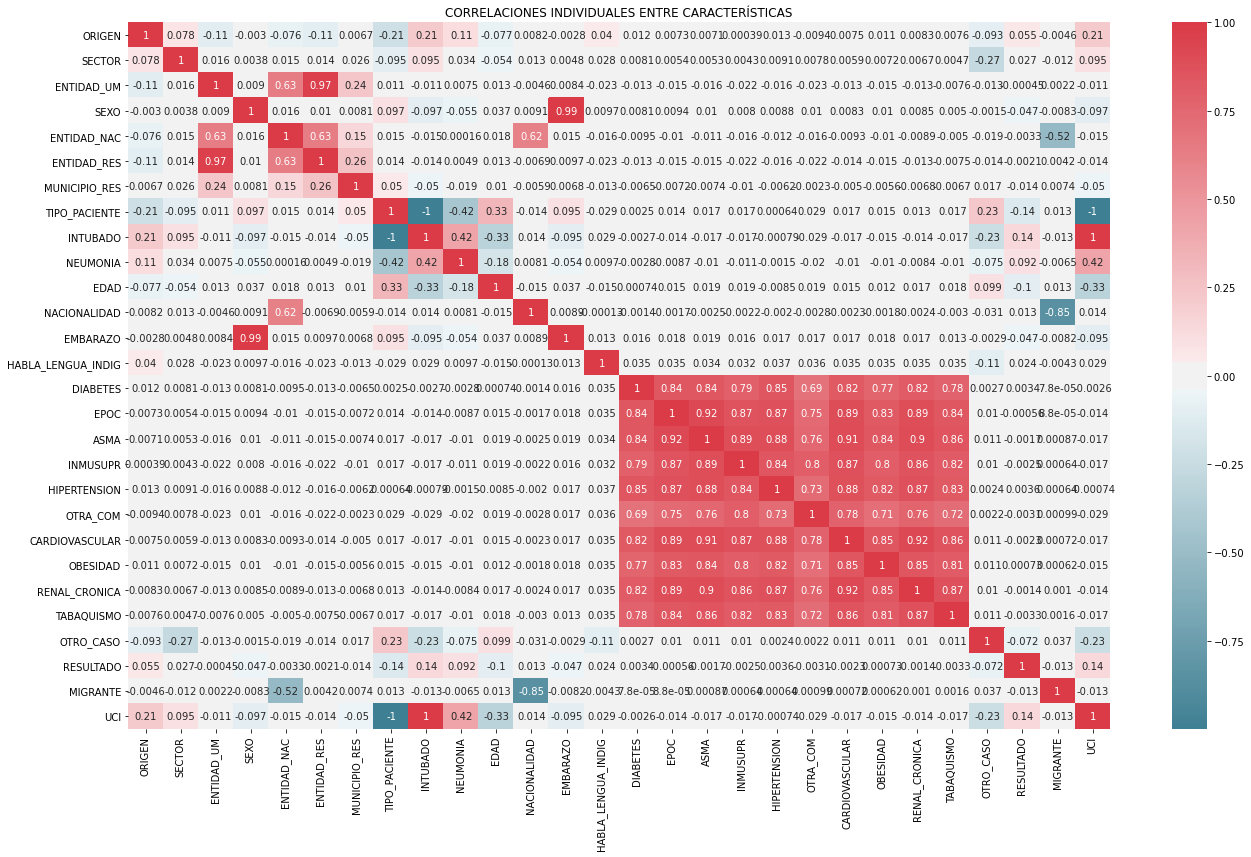

In [163]:
correlation_matrix = data.corr()
plt.figure(figsize = (22,13))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation_matrix, annot=True, cmap=cmap)
plt.title('CORRELACIONES INDIVIDUALES ENTRE CARACTERÍSTICAS')
plt.show()

Es notable encontrar algunas algunas relaciones en aspectos como los padecimientos de salud, tipo de paciente, condiciones de gravedad de su padecimiento, entre otras. Los datos se estudiarán más a fondo en etapas posteriores.

### Limpieza de los datos

In [164]:
from libs.feature_selector import FeatureSelector

fs = FeatureSelector(data=data)

No labels provided. Feature importance based methods are not available.


#### Identificación de valores únicos

El primer paso será determinar cuántos valores únicos existen por cada atributo.

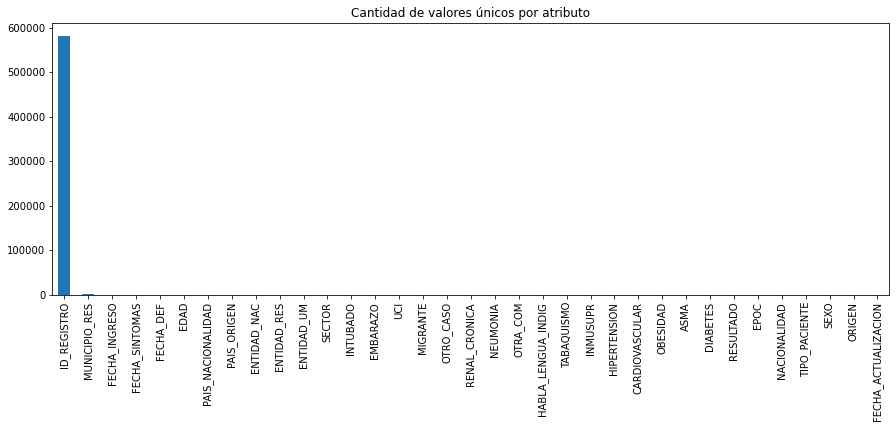

In [165]:
plot_unique(data)

Debido a la gran cantidad de datos, casi todas las barras de la gráfica son imperceptibles, debido a que el campo ID_REGISTRO es un id único para cada paciente estudiado. Esta columna no servirá para el análisis, así que se procede a su eliminación.

In [166]:
drop_attributes(data, ['ID_REGISTRO'])

Se eliminó atributo ID_REGISTRO


Se vuelve a generar la gráfica para visualizar valores únicos.

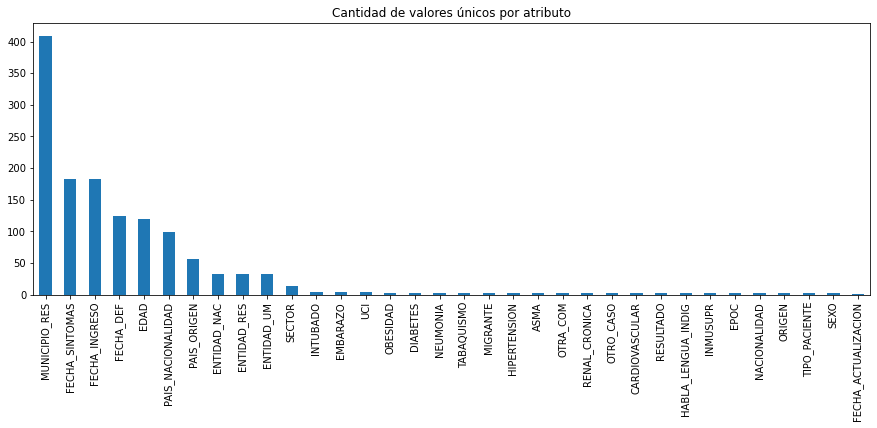

In [167]:
plot_unique(data)

El atributo MUNICIPIO_RES es el que ahora lleva la delantera en cantidad de valores únicos. Al tratarse de un dataset capturado en México, los datos de del origen y de residencia no son de interés, ya que en su mayoría, los registros corresponderán a este país. A continuación se eliminan los campos relacionados y se vuelve a generar la gráfica.

In [168]:
drop_attributes(data, [
    'ENTIDAD_UM',
    'ENTIDAD_NAC',
    'ENTIDAD_RES',
    'MUNICIPIO_RES',
    'HABLA_LENGUA_INDIG',
    'MIGRANTE',
    'PAIS_NACIONALIDAD',
    'PAIS_ORIGEN',
    'NACIONALIDAD'
])

Se eliminó atributo ENTIDAD_UM
Se eliminó atributo ENTIDAD_NAC
Se eliminó atributo ENTIDAD_RES
Se eliminó atributo MUNICIPIO_RES
Se eliminó atributo HABLA_LENGUA_INDIG
Se eliminó atributo MIGRANTE
Se eliminó atributo PAIS_NACIONALIDAD
Se eliminó atributo PAIS_ORIGEN
Se eliminó atributo NACIONALIDAD


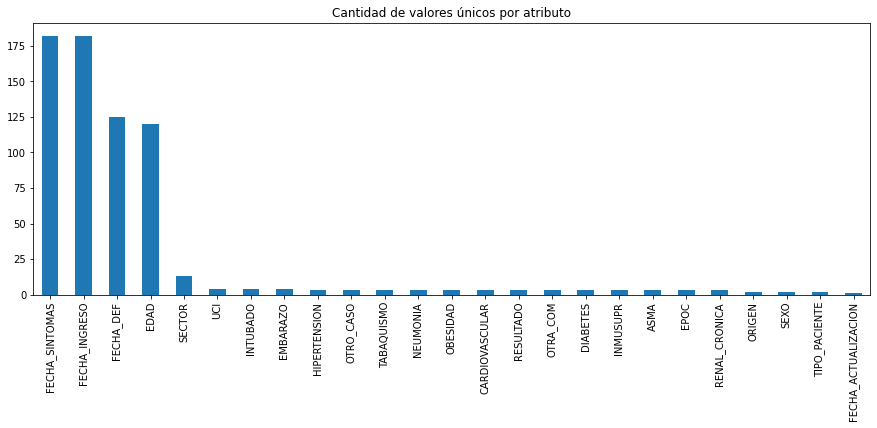

In [169]:
plot_unique(data)

Todavía se tienen atributos con muchos valores únicos o categorías tales como FECHA_INGRESO, FECHA_SINTOMAS, FECHA_DEF y EDAD. Por ahora el dataset se dejará así para darle otros procesamientos requeridos.

#### Identificación de datos faltantes

In [170]:
fs.identify_missing(missing_threshold=0.2)
fs.identify_missing(missing_threshold=0.1)
fs.identify_missing(missing_threshold=0.01)
fs.record_missing

0 features with greater than 0.20 missing values.

0 features with greater than 0.10 missing values.

0 features with greater than 0.01 missing values.



,feature,missing_fraction


#### Identificación de columnas cuyo valor no cambia

In [171]:
fs.identify_single_unique()
fs.record_single_unique

1 features with a single unique value.



,feature,nunique
0,FECHA_ACTUALIZACION,1


In [172]:
drop_attributes(data, ['FECHA_ACTUALIZACION'])

Se eliminó atributo FECHA_ACTUALIZACION


#### Identificación de atributos con alta correlación

12 features with a correlation magnitude greater than 0.50.



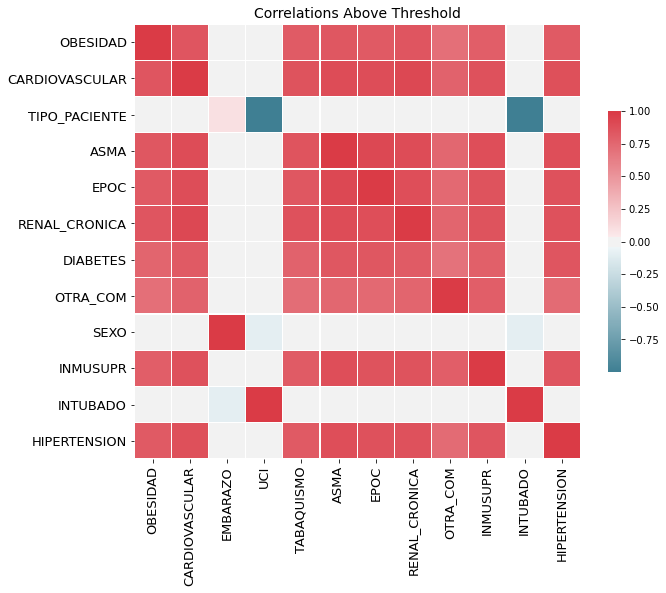

In [173]:
fs.identify_collinear(correlation_threshold=0.5)
fs.plot_collinear()

#### Identificación de outliers en datos numéricos

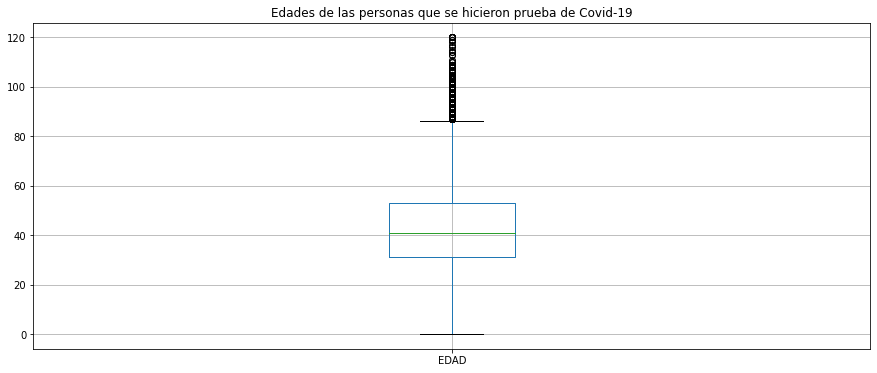

In [174]:
data['EDAD'] = data['EDAD'].astype(float)
data['EDAD'].plot.box(grid=True, figsize=(15, 6))
plt.title('Edades de las personas que se hicieron prueba de Covid-19')
plt.show()

In [175]:
data['EDAD'].describe()

count    581580.000000
mean         42.618240
std          16.650692
min           0.000000
25%          31.000000
50%          41.000000
75%          53.000000
max         120.000000
Name: EDAD, dtype: float64

In [176]:
max_edad = int(data['EDAD'].quantile(0.99))
min_edad = int(data['EDAD'].quantile(0.01))
median_edad = data.loc[data['EDAD'] <= max_edad]['EDAD'].median()
print(f'Rango de edad: {min_edad} a {max_edad} años, mediana: {median_edad}')
data['EDAD'] = data['EDAD'].mask(data['EDAD'] > max_edad, median_edad)

Rango de edad: 2 a 85 años, mediana: 41.0


Los registros de edad van desde los 0 hasta los 120 años, donde la última cantidad evidentemente debe corresponder a un caso muy extraño dentro del dataset, por lo que se procedió a reemplazar los outliers con la edad máxima válida dentro del 99% de los registros.

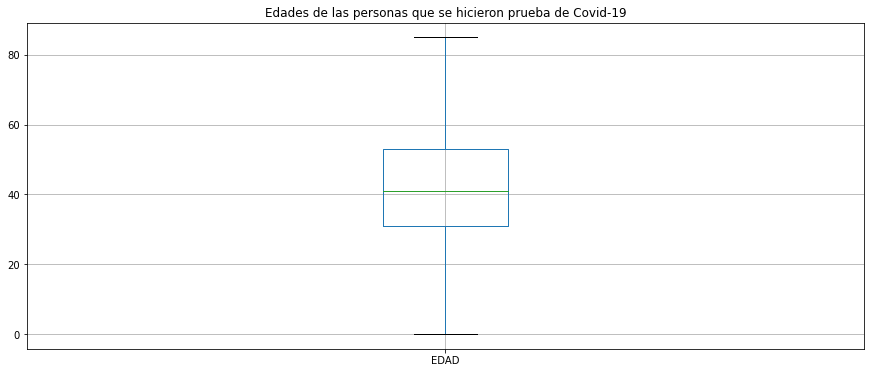

In [177]:
data['EDAD'] = data['EDAD'].astype(float)
data['EDAD'].plot.box(grid=True, figsize=(15, 6))
plt.title('Edades de las personas que se hicieron prueba de Covid-19')
plt.show()

### Selección y extracción de características

In [178]:
original_data = data.copy()

De acuerdo al valor registrado en la columna FECHA_DEF, se crea una nueva característica para determinar si el paciente murió o no.

In [179]:
data['MURIO'] = original_data.apply(lambda row: 2 if row['FECHA_DEF'] == '9999-99-99' else 1, axis = 1)

#### Distribución de clases y valores

A continuación se identifica el tipo de variable para todas las características.

In [180]:
separated_attributes = separate_nums_and_strings(data)
numeric = separated_attributes['numeric']
strings = separated_attributes['strings']
print(f'Numeric: {numeric}')
print()
print(f'Strings: {strings}')

Numeric: ['ORIGEN', 'SECTOR', 'SEXO', 'TIPO_PACIENTE', 'INTUBADO', 'NEUMONIA', 'EDAD', 'EMBARAZO', 'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO', 'OTRO_CASO', 'RESULTADO', 'UCI', 'MURIO']

Strings: ['FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF']


Todas las variables numéricas obtenidas, a excepción de "EDAD", son categóricas y ya se encuentran codificadas numéricamente. Por otro lado, todas las características alfanuméricas que se obtuvieron son también categóricas.

In [181]:
no_category = ['EDAD']
categories = list_diff(numeric, no_category) + strings
parse_categories(data, categories)

Se parsearon los datos categóricos para ser interpretados como tal


In [182]:
describe_attributes(data)


------
ORIGEN
     counts percentaje
2.0  374769     64.44%
1.0  206811     35.56%

------
SECTOR
      counts percentaje
12.0  344924     59.31%
4.0   161488     27.77%
6.0    22575      3.88%
9.0    22260      3.83%
3.0    12226       2.1%
8.0     5629      0.97%
11.0    4082       0.7%
99.0    3696      0.64%
10.0    3423      0.59%
7.0      560       0.1%
13.0     518      0.09%
2.0      131      0.02%
1.0       68      0.01%

----
SEXO
     counts percentaje
2.0  294524     50.64%
1.0  287056     49.36%

-------------
TIPO_PACIENTE
     counts percentaje
1.0  457186     78.61%
2.0  124394     21.39%

-------------
FECHA_INGRESO
            counts percentaje
2020-06-15   13330      2.29%
2020-06-16   12839      2.21%
2020-06-23   12662      2.18%
2020-06-26   12544      2.16%
2020-06-22   12493      2.15%
...            ...        ...
2020-02-01       8       0.0%
2020-02-08       8       0.0%
2020-01-04       6       0.0%
2020-01-11       5       0.0%
2020-01-01       5       0.0

Plotting ORIGEN description
Plotting SECTOR description
Plotting SEXO description
Plotting TIPO_PACIENTE description
Plotting FECHA_INGRESO description
Plotting FECHA_SINTOMAS description
Plotting FECHA_DEF description
Plotting INTUBADO description
Plotting NEUMONIA description
Plotting EDAD description
Plotting EMBARAZO description
Plotting DIABETES description
Plotting EPOC description
Plotting ASMA description
Plotting INMUSUPR description
Plotting HIPERTENSION description
Plotting OTRA_COM description
Plotting CARDIOVASCULAR description
Plotting OBESIDAD description
Plotting RENAL_CRONICA description
Plotting TABAQUISMO description
Plotting OTRO_CASO description
Plotting RESULTADO description
Plotting UCI description
Plotting MURIO description


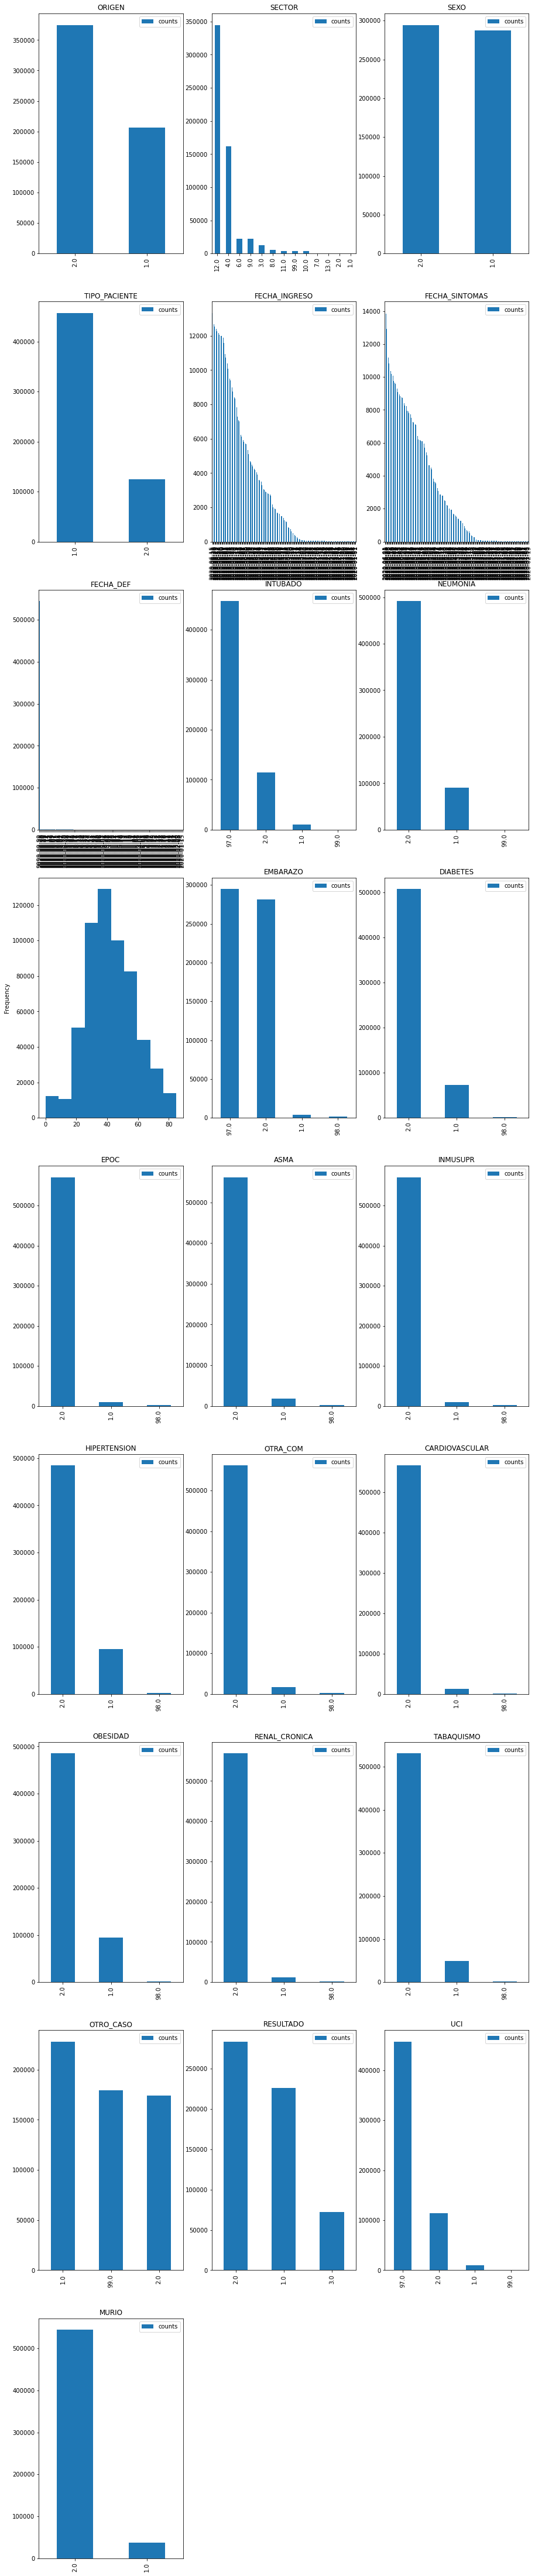

In [183]:
plot_attributes_description(data)

#### Balanceo de clases

In [184]:
data['MURIO'].value_counts()

2.0    544456
1.0     37124
Name: MURIO, dtype: int64

De acuerdo a la visualización de distribución de clases, es posible notar que la mayoría de los pacientes estudiados no murieron. Con el objetivo de balancear las clases de esta característica, se aplica un enfoque de undersamplig al dataset, el cual consiste en igualar la cantidad de registros en cada clase para que sean iguales al de la minoritaria.

In [185]:
def random_undersample(df, attribute, min_value):
    # Cuenta apariciones de clase minotaria
    min_rows_count = len(df[df[attribute] == min_value])
    print(f'Hay {min_rows_count} registros de la clase minotaria')
    
    # Obtiene índices de clase mayotaria y elige un subconjunto al azar, para tener
    # la misma cantidad de registro en cada clase
    max_rows_indexes = df[df[attribute] == 2].index
    random_indexes = np.random.choice(max_rows_indexes, min_rows_count, replace=False)
    
    # Obtiene índices de la clase minotaria y los combina con el subconjunto de la mayotaria.
    min_rows_indexes = df[df[attribute] == 1].index
    under_sample_indexes = np.concatenate([min_rows_indexes, random_indexes])
    
    # Balancea el dataset
    return df.loc[under_sample_indexes]   

In [186]:
data = random_undersample(data, 'MURIO', 1) 

Hay 37124 registros de la clase minotaria


In [187]:
data['MURIO'].value_counts()

1.0    37124
2.0    37124
Name: MURIO, dtype: int64

Plotting ORIGEN description
Plotting SECTOR description
Plotting SEXO description
Plotting TIPO_PACIENTE description
Plotting FECHA_INGRESO description
Plotting FECHA_SINTOMAS description
Plotting FECHA_DEF description
Plotting INTUBADO description
Plotting NEUMONIA description
Plotting EDAD description
Plotting EMBARAZO description
Plotting DIABETES description
Plotting EPOC description
Plotting ASMA description
Plotting INMUSUPR description
Plotting HIPERTENSION description
Plotting OTRA_COM description
Plotting CARDIOVASCULAR description
Plotting OBESIDAD description
Plotting RENAL_CRONICA description
Plotting TABAQUISMO description
Plotting OTRO_CASO description
Plotting RESULTADO description
Plotting UCI description
Plotting MURIO description


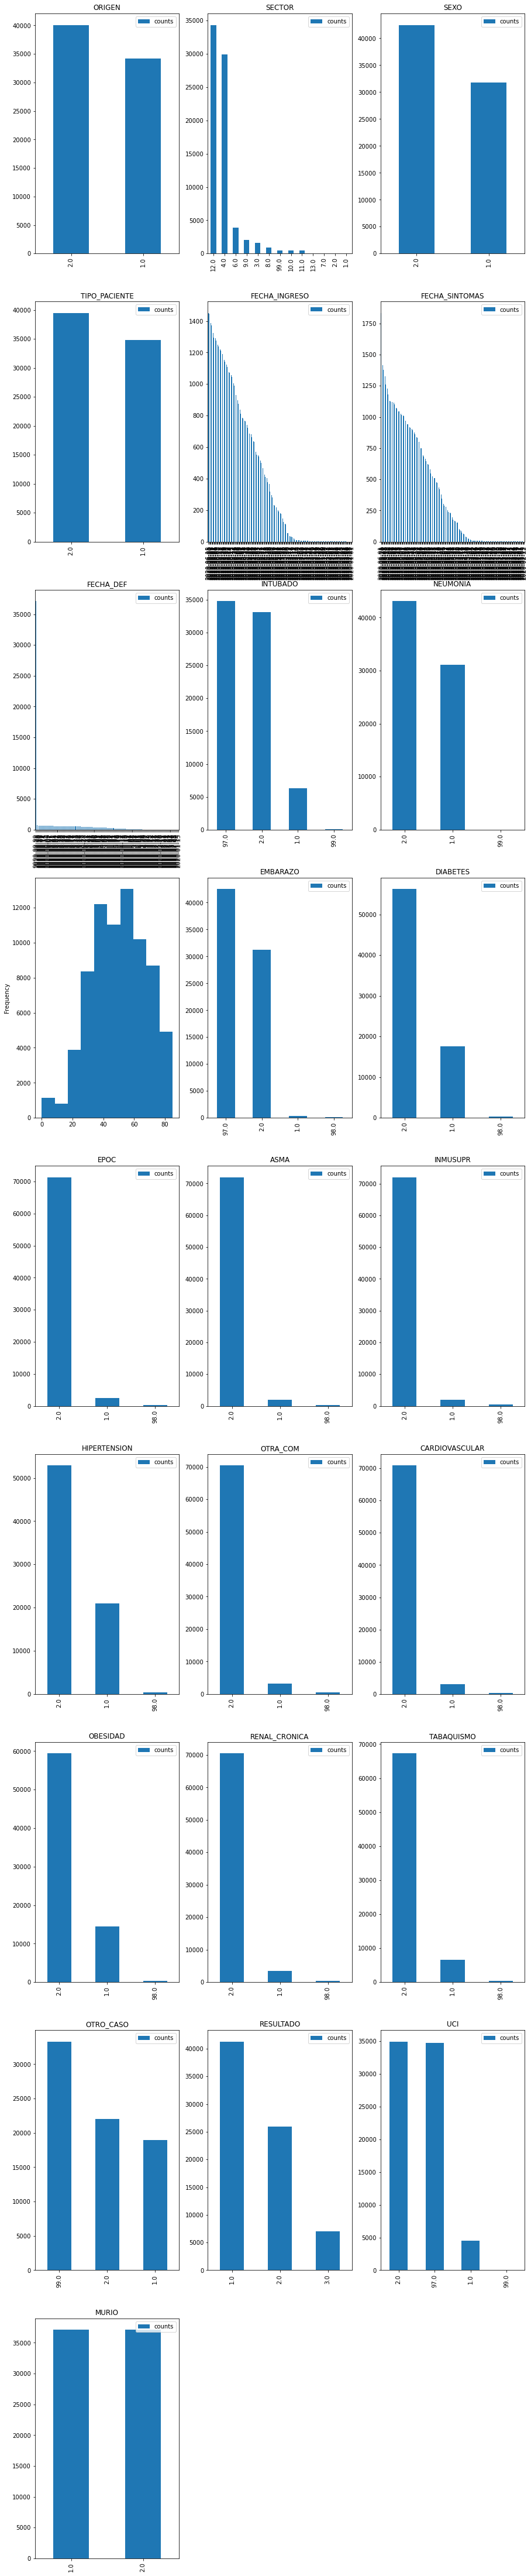

In [188]:
plot_attributes_description(data)

Por medio del balanceo aplicado, ahora se tiene la misma cantidad de registros de pacientes que murieron y que sobrevivieron, aún existen algunas clases desbalanceadas, más adelante se determinará si es necesario realizar más procesamientos similares.

### Tiempos transcurridos a partir de fechas

En lugar de trabajar con fechas, que pudieran no ser de mucha utilidad, se generarán datos más relevantes, de acuerdo a los tiempos transcurridos en cada etapa de la enfermedad de los pacientes.

In [189]:
data['FECHA_DEF'] = data['FECHA_DEF'].astype('str')
data['FECHA_SINTOMAS'] = data['FECHA_SINTOMAS'].astype('str')
data['FECHA_INGRESO'] = data['FECHA_INGRESO'].astype('str')

Ya se determinó si el paciente murió o no, por lo que la fecha de defunción para los pacientes que no murieron se reemplazará por la fecha del dataset. Lo anterior con la finalidad de poder hacer cálculos de los tiempos que llevan los pacientes enfermos y hospitalizados hasta el momento.

In [190]:
from datetime import datetime

def str_to_date(date_str):
    return datetime.strptime(date_str, '%Y-%m-%d')

data['FECHA_DEF'] = data['FECHA_DEF'].mask(data['FECHA_DEF'] == '9999-99-99', '2020-06-30')

data['DIAS_INGRESO'] = data.apply(lambda row: (str_to_date(row['FECHA_INGRESO']) - 
                                  str_to_date(row['FECHA_SINTOMAS'])).days, axis = 1)

#data['DIAS_ENFERMEDAD'] = data.apply(lambda row: (str_to_date(row['FECHA_DEF']) - 
#                                  str_to_date(row['FECHA_SINTOMAS'])).days, axis = 1)

#data['DIAS_HOSPITALIZACION'] = data.apply(lambda row: (str_to_date(row['FECHA_DEF']) - 
#                                  str_to_date(row['FECHA_INGRESO'])).days, axis = 1)

In [191]:
print(f"Fecha síntomas: {data['FECHA_SINTOMAS'].min()} a {data['FECHA_SINTOMAS'].max()}")
print(f"Fecha ingreso: {data['FECHA_INGRESO'].min()} a {data['FECHA_INGRESO'].max()}")
print(f"Fecha defunción: {data['FECHA_DEF'].min()} a {data['FECHA_DEF'].max()}")

Fecha síntomas: 2020-01-01 a 2020-06-30
Fecha ingreso: 2020-01-02 a 2020-06-30
Fecha defunción: 2020-01-13 a 2020-06-30


In [192]:
print('DIAS_INGRESO')
data['DIAS_INGRESO'].describe()

DIAS_INGRESO


count    74248.000000
mean         3.858340
std          3.413199
min          0.000000
25%          1.000000
50%          3.000000
75%          6.000000
max        115.000000
Name: DIAS_INGRESO, dtype: float64

In [193]:
drop_attributes(data, ['FECHA_DEF', 'FECHA_SINTOMAS', 'FECHA_INGRESO'])

Se eliminó atributo FECHA_DEF
Se eliminó atributo FECHA_SINTOMAS
Se eliminó atributo FECHA_INGRESO


Plotting ORIGEN description
Plotting SECTOR description
Plotting SEXO description
Plotting TIPO_PACIENTE description
Plotting INTUBADO description
Plotting NEUMONIA description
Plotting EDAD description
Plotting EMBARAZO description
Plotting DIABETES description
Plotting EPOC description
Plotting ASMA description
Plotting INMUSUPR description
Plotting HIPERTENSION description
Plotting OTRA_COM description
Plotting CARDIOVASCULAR description
Plotting OBESIDAD description
Plotting RENAL_CRONICA description
Plotting TABAQUISMO description
Plotting OTRO_CASO description
Plotting RESULTADO description
Plotting UCI description
Plotting MURIO description
Plotting DIAS_INGRESO description


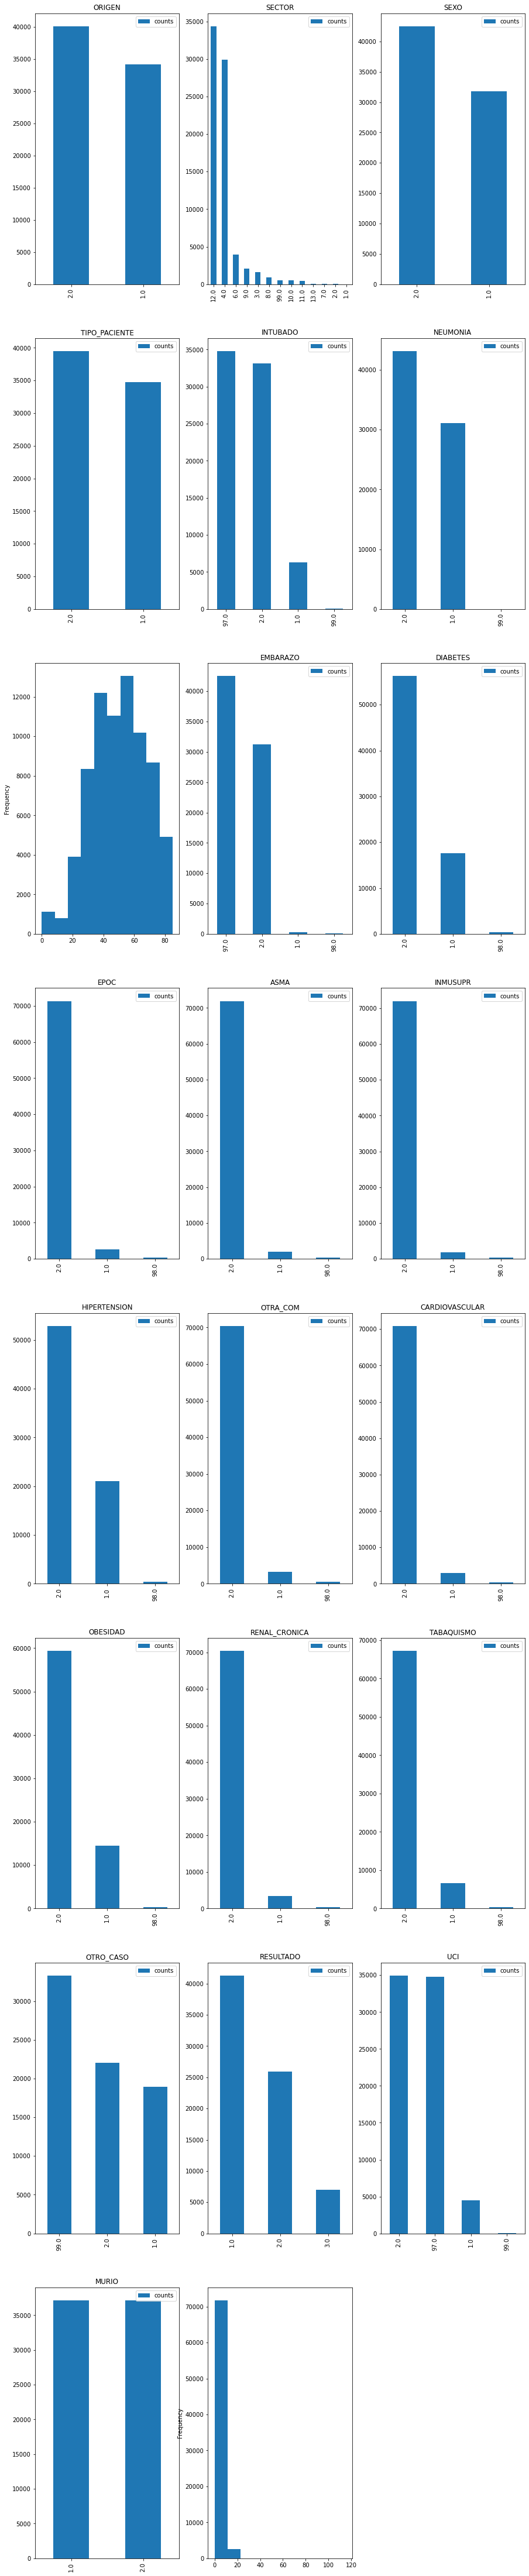

In [194]:
plot_attributes_description(data)

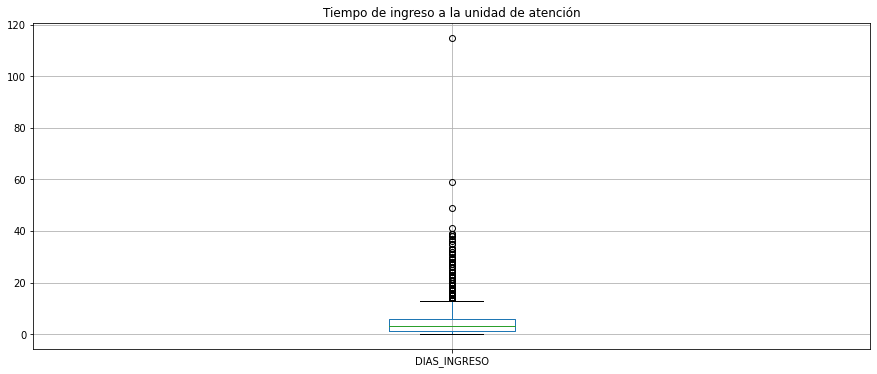

In [195]:
#data['EDAD'] = data['EDAD'].astype(float)
data['DIAS_INGRESO'].plot.box(grid=True, figsize=(15, 6))
plt.title('Tiempo de ingreso a la unidad de atención')
plt.show()

In [196]:
max_ingreso = int(data['DIAS_INGRESO'].quantile(0.99))
min_ingreso = int(data['DIAS_INGRESO'].quantile(0.01))
print(f'Rango de días de ingreso: {min_ingreso} -> {max_ingreso}')
data['DIAS_INGRESO'].describe()
#median_edad = data.loc[data['EDAD'] <= max_edad].median()
#print(f'Rango de edad: {min_edad} -> {max_edad}, mediana: {median_edad}')
#data['EDAD'] = data['EDAD'].mask(data['EDAD'] > max_edad, median_edad)

Rango de días de ingreso: 0 -> 14


count    74248.000000
mean         3.858340
std          3.413199
min          0.000000
25%          1.000000
50%          3.000000
75%          6.000000
max        115.000000
Name: DIAS_INGRESO, dtype: float64

#### Wrapper methods

In [197]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

In [198]:
backup = data.copy()

In [199]:
x = backup.drop('MURIO', 1)
y = backup['MURIO']

In [200]:
print(f'Quedan {len(backup.columns)} características')

Quedan 23 características


Como parte de la selección de características, a continuación se aplica Sequential Forward (y Backward) Selection con regresión lineal para determinar si un paciente morirá.

#### Sequential Forward Selection

In [201]:
def seq_for_sel(algorithm, k_features, forward, floating, scoring, cv):
    sfs1 = SFS(algorithm,
           k_features=k_features,
           forward=forward,
           floating=floating,
           scoring = scoring,
           verbose=2,
           cv = cv)  # Cross validation

    sfs1.fit(x, y)

    print(f'Features: {sfs1.k_feature_names_}\n')
    print(f'Score: {sfs1.k_score_}\n')
    print(f'Subsets: {sfs1.subsets_}\n')
    
    fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev')
    plt.title('Sequential Forward Selection (w. StdErr)')
    plt.grid()
    plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished

[2020-07-10 13:24:56] Features: 1/15 -- score: 0.544264870174819[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished

[2020-07-10 13:24:56] Features: 2/15 -- score: 0.5828888130785187[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.3s finished

[2020-07-10 13:24:56] Features: 3/15 -- score: 0.5979339887339836[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

Features: ('ORIGEN', 'SECTOR', 'SEXO', 'TIPO_PACIENTE', 'INTUBADO', 'NEUMONIA', 'EDAD', 'DIABETES', 'ASMA', 'HIPERTENSION', 'OTRA_COM', 'OTRO_CASO', 'RESULTADO', 'UCI', 'DIAS_INGRESO')

Score: 0.6240856920926767

Subsets: {1: {'feature_idx': (3,), 'cv_scores': array([0.54426487]), 'avg_score': 0.544264870174819, 'feature_names': ('TIPO_PACIENTE',)}, 2: {'feature_idx': (3, 6), 'cv_scores': array([0.58288881]), 'avg_score': 0.5828888130785187, 'feature_names': ('TIPO_PACIENTE', 'EDAD')}, 3: {'feature_idx': (3, 6, 19), 'cv_scores': array([0.59793399]), 'avg_score': 0.5979339887339836, 'feature_names': ('TIPO_PACIENTE', 'EDAD', 'RESULTADO')}, 4: {'feature_idx': (3, 5, 6, 19), 'cv_scores': array([0.60970077]), 'avg_score': 0.6097007678707818, 'feature_names': ('TIPO_PACIENTE', 'NEUMONIA', 'EDAD', 'RESULTADO')}, 5: {'feature_idx': (3, 5, 6, 18, 19), 'cv_scores': array([0.61923317]), 'avg_score': 0.6192331732967279, 'feature_names': ('TIPO_PACIENTE', 'NEUMONIA', 'EDAD', 'OTRO_CASO', 'RESULTAD

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.6s finished

[2020-07-10 13:25:03] Features: 15/15 -- score: 0.6240856920926767/home/porfirio/anaconda3/envs/venv/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/porfirio/anaconda3/envs/venv/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


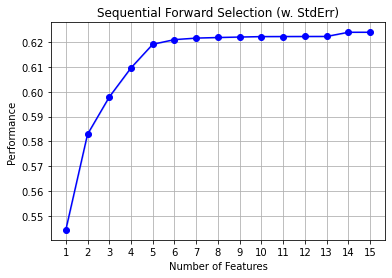

In [202]:
seq_for_sel(LinearRegression(), (3, 15), True, False, 'r2', 0)

#### Sequential Forward Floating Selection

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.2s finished

[2020-07-10 13:25:03] Features: 1/15 -- score: 0.544264870174819[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2020-07-10 13:25:03] Features: 2/15 -- score: 0.5828888130785187[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

Features: ('ORIGEN', 'SECTOR', 'SEXO', 'TIPO_PACIENTE', 'INTUBADO', 'NEUMONIA', 'EDAD', 'DIABETES', 'ASMA', 'HIPERTENSION', 'OTRA_COM', 'OTRO_CASO', 'RESULTADO', 'UCI', 'DIAS_INGRESO')

Score: 0.6240856920926767

Subsets: {1: {'feature_idx': (3,), 'cv_scores': array([0.54426487]), 'avg_score': 0.544264870174819, 'feature_names': ('TIPO_PACIENTE',)}, 2: {'feature_idx': (3, 6), 'cv_scores': array([0.58288881]), 'avg_score': 0.5828888130785187, 'feature_names': ('TIPO_PACIENTE', 'EDAD')}, 3: {'feature_idx': (3, 6, 19), 'cv_scores': array([0.59793399]), 'avg_score': 0.5979339887339836, 'feature_names': ('TIPO_PACIENTE', 'EDAD', 'RESULTADO')}, 4: {'feature_idx': (3, 5, 6, 19), 'cv_scores': array([0.60970077]), 'avg_score': 0.6097007678707818, 'feature_names': ('TIPO_PACIENTE', 'NEUMONIA', 'EDAD', 'RESULTADO')}, 5: {'feature_idx': (3, 5, 6, 18, 19), 'cv_scores': array([0.61923317]), 'avg_score': 0.6192331732967279, 'feature_names': ('TIPO_PACIENTE', 'NEUMONIA', 'EDAD', 'OTRO_CASO', 'RESULTAD

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.9s finished

[2020-07-10 13:25:15] Features: 15/15 -- score: 0.6240856920926767/home/porfirio/anaconda3/envs/venv/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/porfirio/anaconda3/envs/venv/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


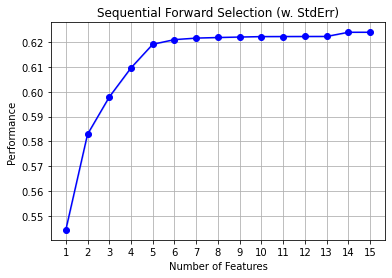

In [203]:
seq_for_sel(LinearRegression(), (3, 15), True, True, 'r2', 0)

#### Sequential Backward Selection

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    2.1s finished

[2020-07-10 13:25:18] Features: 21/3 -- score: 0.6240977065672901[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    1.9s finished

[2020-07-10 13:25:20] Features: 20/3 -- score: 0.6240962036291224[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.8s finished

[2020-07-10 13:25:21] Features: 19/3 -- score: 0.6240946976659246[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

Features: ('ORIGEN', 'SECTOR', 'SEXO', 'TIPO_PACIENTE', 'INTUBADO', 'NEUMONIA', 'EDAD', 'DIABETES', 'ASMA', 'HIPERTENSION', 'OTRA_COM', 'OTRO_CASO', 'RESULTADO', 'UCI', 'DIAS_INGRESO')

Score: 0.6240856920926767

Subsets: {22: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21), 'cv_scores': array([0.62409775]), 'avg_score': 0.6240977507496731, 'feature_names': ('ORIGEN', 'SECTOR', 'SEXO', 'TIPO_PACIENTE', 'INTUBADO', 'NEUMONIA', 'EDAD', 'EMBARAZO', 'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO', 'OTRO_CASO', 'RESULTADO', 'UCI', 'DIAS_INGRESO')}, 21: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21), 'cv_scores': array([0.62409771]), 'avg_score': 0.6240977065672901, 'feature_names': ('ORIGEN', 'SECTOR', 'SEXO', 'TIPO_PACIENTE', 'INTUBADO', 'NEUMONIA', 'EDAD', 'EMBARAZO', 'DIABETES', 'EPOC', 'ASMA', 'HIPERTENSION', 'OTRA_COM

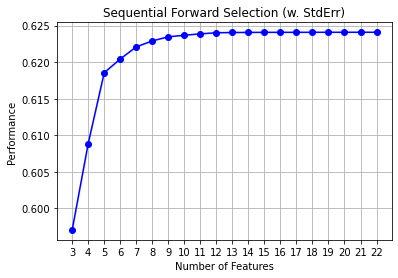

In [204]:
seq_for_sel(LinearRegression(), (3, 15), False, False, 'r2', 0)

Con la regresión se obtuvieron scores de alrededor de 0.6, el cual puede considerarse bueno, sin embargo, se aplicará también random forest para ver con cual enfoque se obtienen mejores resultados.

#### Random forest

In [205]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc

# Divide en entrenamiento y prueba.
X_train, X_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.25,
    random_state=42)

y_train = y_train.ravel()
y_test = y_test.ravel()

print('Training dataset shape:', X_train.shape, y_train.shape)
print('Testing dataset shape:', X_test.shape, y_test.shape)

Training dataset shape: (55686, 22) (55686,)
Testing dataset shape: (18562, 22) (18562,)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:   41.3s finished

[2020-07-10 13:26:14] Features: 1/8 -- score: 0.8681312489612039[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   43.5s finished

[2020-07-10 13:26:57] Features: 2/8 -- score: 0.8828655187246339[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   47.3s finished

[2020-07-10 13:27:44] Features: 3/8 -- score: 0.8859767005815898[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 

Features: ('TIPO_PACIENTE', 'INTUBADO', 'NEUMONIA', 'EDAD', 'ASMA', 'RENAL_CRONICA', 'OTRO_CASO', 'UCI')

Score: 0.8903134408262025

Subsets: {1: {'feature_idx': (3,), 'cv_scores': array([0.86767677, 0.86545455, 0.86228956, 0.86901475, 0.87622062]), 'avg_score': 0.8681312489612039, 'feature_names': ('TIPO_PACIENTE',)}, 2: {'feature_idx': (3, 5), 'cv_scores': array([0.88518519, 0.88363636, 0.88074074, 0.88160819, 0.88315711]), 'avg_score': 0.8828655187246339, 'feature_names': ('TIPO_PACIENTE', 'NEUMONIA')}, 3: {'feature_idx': (3, 5, 18), 'cv_scores': array([0.88673401, 0.88949495, 0.88363636, 0.88315711, 0.88686107]), 'avg_score': 0.8859767005815898, 'feature_names': ('TIPO_PACIENTE', 'NEUMONIA', 'OTRO_CASO')}, 4: {'feature_idx': (3, 5, 6, 18), 'cv_scores': array([0.89434343, 0.89494949, 0.89131313, 0.88854468, 0.88335915]), 'avg_score': 0.8905019785027866, 'feature_names': ('TIPO_PACIENTE', 'NEUMONIA', 'EDAD', 'OTRO_CASO')}, 5: {'feature_idx': (3, 4, 5, 6, 18), 'cv_scores': array([0.89

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.2min finished

[2020-07-10 13:33:38] Features: 8/8 -- score: 0.8903134408262025

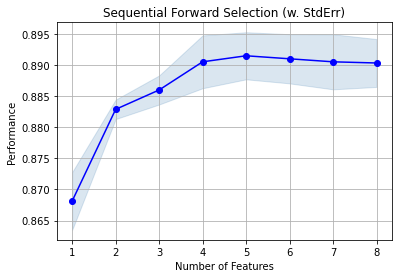

In [206]:
# Construye clasificador RF para la selección de características.
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
seq_for_sel(clf, (8), True, False, 'accuracy', 5)

Es interesante ver cómo desde la primer característica analizada se obtiene un score mayor a 0.8, pero al momento de ver cuáles atributos está tomando en cuenta para determinar si el paciente morirá o no, es evidente que algunos son muy obvios y en realidad podrían no resultar de mucha utilidad.

Por ejemplo, la columna INTUBADO determina si el paciente requirió intubación. En la atención al Covid-19, muchos pacientes pueden regresar a aislarse en su casa y ahí recuperarse, por lo que los pacientes que son hospitalizados y más aún, cuando los intuban, significa que su padecimiento es muy grave y aumenta muchísimo las posibilidades de que muera.

Lo que se busca en este trabajo es predecir si el paciente morirá, pero analizando características no tan obvias y que permitan tomar decisiones en un momento temprano. Por este motivo se eliminarán las características que pudieran hacer obvia la muerte y se volverá a aplicar el selector.

In [207]:
drop_attributes(backup, [
    'TIPO_PACIENTE', # Si el paciente fue hospitalizado es porque está grave.
    'INTUBADO', # Requiere hospitalización
    'UCI', # Requiere hospitalización
    'NEUMONIA', # Requiere hospitalización
    'SECTOR', # Irrelevante para el objetivo de estudio
    'ORIGEN', # Irrelevante para el objetivo de estudio
    'OTRO_CASO' # El contacto con un caso positivo es muy probable que conlleve a contraer Covid-19
])

Se eliminó atributo TIPO_PACIENTE
Se eliminó atributo INTUBADO
Se eliminó atributo UCI
Se eliminó atributo NEUMONIA
Se eliminó atributo SECTOR
Se eliminó atributo ORIGEN
Se eliminó atributo OTRO_CASO


In [208]:
x = backup.drop('MURIO', 1)
y = backup['MURIO']

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   25.9s finished

[2020-07-10 13:34:04] Features: 1/8 -- score: 0.7448684242927627[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:   49.6s finished

[2020-07-10 13:34:54] Features: 2/8 -- score: 0.755414178147561[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:   51.2s finished

[2020-07-10 13:35:45] Features: 3/8 -- score: 0.7637241247639255[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 o

Features: ('SEXO', 'EDAD', 'EMBARAZO', 'DIABETES', 'INMUSUPR', 'HIPERTENSION', 'OBESIDAD', 'RENAL_CRONICA')

Score: 0.7688017218450244

Subsets: {1: {'feature_idx': (1,), 'cv_scores': array([0.74760943, 0.75030303, 0.74592593, 0.74530271, 0.73520102]), 'avg_score': 0.7448684242927627, 'feature_names': ('EDAD',)}, 2: {'feature_idx': (1, 3), 'cv_scores': array([0.75925926, 0.76013468, 0.75494949, 0.75715536, 0.74557209]), 'avg_score': 0.755414178147561, 'feature_names': ('EDAD', 'DIABETES')}, 3: {'feature_idx': (1, 2, 3), 'cv_scores': array([0.76774411, 0.77097643, 0.76363636, 0.76665095, 0.74961277]), 'avg_score': 0.7637241247639255, 'feature_names': ('EDAD', 'EMBARAZO', 'DIABETES')}, 4: {'feature_idx': (1, 2, 3, 7), 'cv_scores': array([0.76989899, 0.77380471, 0.76767677, 0.77008553, 0.75183514]), 'avg_score': 0.7666602278877852, 'feature_names': ('EDAD', 'EMBARAZO', 'DIABETES', 'HIPERTENSION')}, 5: {'feature_idx': (1, 2, 3, 7, 11), 'cv_scores': array([0.76996633, 0.77461279, 0.76962963

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   40.6s finished

[2020-07-10 13:39:39] Features: 8/8 -- score: 0.7688017218450244

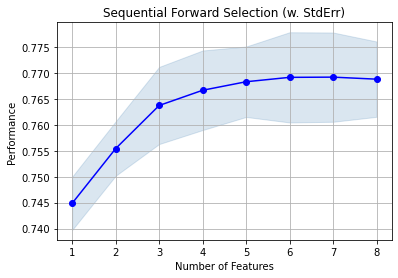

In [209]:
seq_for_sel(clf, (8), True, False, 'accuracy', 5)

El mejor rendimiento del Random Forest se obtuvo con 6 características y posteriormente comienza a bajar, los algoritmos de Machine Learning se aplicarán utilizando los siguientes atributos:

- SEXO
- EDAD
- DIABETES
- HIPERTENSION
- OBESIDAD
- RENAL_CRONICA

## Machine Learning

In [210]:
from pandas import read_csv
from matplotlib import pyplot
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import SCORERS
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

En el siguiente paso se eliminan las características que no se usarán en el análisis.

In [211]:
atributos_menos_utiles = backup.columns.difference([
    'SEXO', 
    'EDAD', 
    'DIABETES', 
    'HIPERTENSION', 
    'OBESIDAD', 
    'RENAL_CRONICA',
    'MURIO'
])

atributos_menos_utiles

drop_attributes(backup, atributos_menos_utiles)

Se eliminó atributo ASMA
Se eliminó atributo CARDIOVASCULAR
Se eliminó atributo DIAS_INGRESO
Se eliminó atributo EMBARAZO
Se eliminó atributo EPOC
Se eliminó atributo INMUSUPR
Se eliminó atributo OTRA_COM
Se eliminó atributo RESULTADO
Se eliminó atributo TABAQUISMO


Se procede a generar los conjuntos de datos de entrenamiento y prueba.

In [212]:
y = backup.pop('MURIO')
x = backup

# Divide en entrenamiento y prueba.
X_train, X_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.25,
    random_state=42)

y_train = y_train.ravel()
y_test = y_test.ravel()

print('Training dataset shape:', X_train.shape, y_train.shape)
print('Testing dataset shape:', X_test.shape, y_test.shape)

Training dataset shape: (55686, 6) (55686,)
Testing dataset shape: (18562, 6) (18562,)


Prepara los modelos que se aplicarán al dataset.

In [213]:
models = []
models.append(( 'LOR' , LogisticRegression()))
models.append(( 'LIR' , LinearRegression()))
models.append(( 'LDA' , LinearDiscriminantAnalysis()))
models.append(( 'KNN' , KNeighborsClassifier()))
models.append(( 'CART' , DecisionTreeClassifier()))
models.append(( 'NB' , GaussianNB()))
models.append(( 'SVM' , SVC()))

In [214]:
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

Ejecuta cada uno de los algoritmos especificados.

LOR


/home/porfirio/anaconda3/envs/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


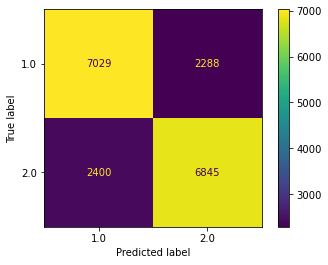

LOR: 0.688544 (0.013501)
LIR


/home/porfirio/anaconda3/envs/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


LIR: -181.899964 (545.699892)
LDA


/home/porfirio/anaconda3/envs/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


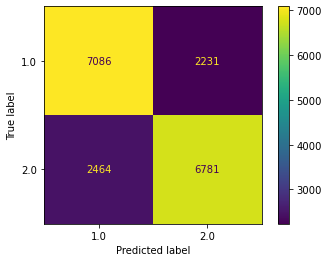

LDA: 0.688867 (0.014075)
KNN


/home/porfirio/anaconda3/envs/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


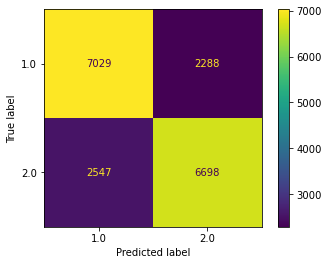

KNN: 0.488594 (0.437187)
CART


/home/porfirio/anaconda3/envs/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


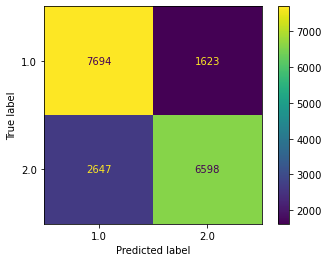

CART: 0.734968 (0.036994)
NB


/home/porfirio/anaconda3/envs/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


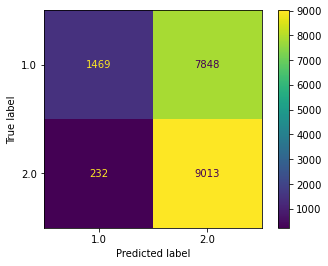

NB: 0.531420 (0.430967)
SVM


/home/porfirio/anaconda3/envs/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


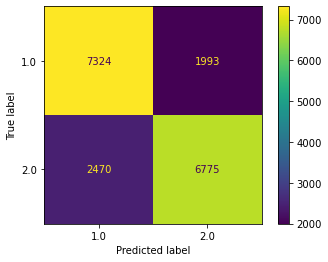

SVM: 0.701257 (0.023850)


In [215]:
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    print(name)
    scoring = 'accuracy' if name != 'LIR' else 'r2'
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, x, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    model.fit(X_train, y_train)
    if name != 'LIR':
        plot_confusion_matrix(model, X_test, y_test)
        plt.show()
    print(msg)


## Resultados

Se aplicaron una serie de algoritmos de machine learning al conjunto de datos, donde el mejor resultado se obtuvo por medio de árboles de decisión, obtieniendo un accuracy de aproximadamente 0.73, valor muy bueno para la predicción de la muerte de pacientes por Covid-19.

En cuanto a las predicciones hechas con este algoritmo, el 81% de los pacientes que se dijo que moriría, en realidad sí murieron, y el 19% restante no murió.

Por otro lado, el 72% de los que se dijo que no morirían, siguen vivos, y el 23% desafortunadamente murieron.

La gravedad de un error en las predicciones, depende de qué uso se le vaya a dar a la información, por ejemplo, en un caso ideal, para los pacientes que sobrevivieron siendo que se había pronosticado que morirían, no habría afectaciones más que la buena noticia que recibirían sus familias.

Pero en un caso extremo, donde esta información se utilizara para decidir las prioridades de atención médica para pacientes por Covid-19 de acuerdo a sus posibilidades de sobrevivir, a estos pacientes que no murieron, se les habría podido negar la atención ya que no había muchas esperanzas, y aunque se habrían recuperado, el no tener la atención médica podría desencadenar su muerte.

De manera similar se puede pensar que que el 23% de las personas que murieron, cuando se había determinado que no sucedería, utilizaron recursos médicos que pudieron haber sido mejor aprovechados en pacientes con mayores posibilidades de recuperarse.

Cabe destacar que con el uso de Naive Bayes, si bien no tuvo el mejor de los rendimientos, su nivel de error en cuanto a los pacientes que clasifica como sobrevivientes y que terminan muriendo, es tan solo del 3% aproximadamente, por lo que si es de vital importancia asegurar los recursos médicos para los pacientes que no morirán, este modelo podría ser usado como una confirmación para un resultado obtenido con árboles de decisión. Es importante resaltar que solo podria usarse en este caso particular, ya que la clasificación de muertos es muy inexacta, solo lo hizo bien en el 17% de los casos.

## Conclusiones

El análisis de datos es una herramienta muy útil para la vida cotidiana actual, donde a cada momento se está generando una cantidad enorme de información. Darle a los datos un procesamiento permite encontrar patrones, relaciones y comportamientos que pueden ayudar a la toma de decisiones y al entendimiento de algún fenómeno.

Como complemento a la tarea anteriormente descrita, los algoritmos de Machine Learning permiten automatizar los cálculos que hay que llevar a cabo para la formulación de conclusiones, cabe destacar que sin este tipo de herramientas sería muy complicado analizar cantidades grandes de datos, ya que la velocidad de procesamiento de los equipos de cómputo permiten llevar a cabo estos análisis de una forma rápida y exacta.

El campo de la medicina es una de las mayores áreas de interés para el análisis de datos, ya que se busca aprovechar las bondades de las ciencias computacionales para mejorar la atención médica que se otorga, incluso para obtener información que a simple vista, sería imposible coseguir.

La implementación de herramientas de análisis de datos aplicadas a situaciones como la actual pandemia por Covid-19, puede ayudar a entender mejor el comportamiento de la enfermedad en un sector de la población. En el presente trabajo se estudiaron los datos correspondientes al seguimiento de los pacientes en México, cuyas características particulares conllevan a que la gravedad de la enfermedad sea diferente en este país que en algún otro.

Por medio de los algoritmos de clasificación utilizados, fue posible determinar si un paciente que presentó síntomas de Covid-19, así como con el estudio de otros factores relacionados a su salud, morirá o no.

## Trabajo futuro

El análisis de datos de Covid-19 abre un mar de posibilidades de estudio. En este trabajo se hizo hincapié en los aspectos de salud de un paciente que pueden determinar si morirá o no, pero el descenlace que tendrá la enfermedad en cada persona, no se limita a esta opción, sino que existen más variables que se pueden analizar para obtener otro tipo de resultados.

En un futuro sería interesante estimar el tiempo en que un paciente se recuperará o moriá, hecho que podría ayudar mucho en la implementación de la logística que se lleva a cabo en las unidades de salud para el combate de la enfermedad en cuestión.

Por otro lado, también podrían aplicarse más algoritmos de machine learning a los datos para comparar los resultados que se obtienen.